# Multiple Time Series, Pre-trained Models and Covariates

This notebook serves as a tutorial for:
* Training a single model on multiple time series
* Using a pre-trained model to obtain forecasts for any time series unseen during training
* Training and using a model using covariates

First, some necessary imports:

In [2]:
import gc
gc.collect()

242

In [3]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import rc
import time
from darts import TimeSeries
from darts.utils.timeseries_generation import gaussian_timeseries, linear_timeseries, sine_timeseries
from darts.models import RNNModel, TCNModel, TransformerModel, NBEATSModel
from darts.metrics import mape, smape, mse, rmse, ope, r2_score, rmsle, coefficient_of_variation, metrics, mae
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
window = 7
torch.manual_seed(1); np.random.seed(1)  # for reproducibility

### Read Data


In [4]:
df = pd.read_excel("C:/Users/KAPLAN/Desktop/masterthesis_fulldata_interpolated_ready.xlsx", engine='openpyxl')

In [5]:
list(df.columns.values)
list(df)

['Date',
 'Daily_Sum_CrudeBERT',
 'Label_CrudeBERT',
 'Cuml_CurdeBERT',
 'Daily_Sum_CrudeBERTv2',
 'Label_CrudeBERTv2',
 'Cuml_CrudeBERTv2',
 'Daily_Sum_CrudeBERTv2_GT',
 'Label_CrudeBERTv2_GT',
 'Cuml_CrudeBERTv2_GT',
 'Daily_Sum_CrudeBERT_T4',
 'Label_CrudeBERT_T4',
 'Cuml_CrudeBERT_T4',
 'Daily_Sum_FinBERT',
 'Label_FinBERT',
 'Cuml_FinBERT',
 'Daily_Sum_RavenPack',
 'Label_RavenPack',
 'Cuml_RavenPack',
 'Price_t0',
 'Return_t0',
 'Label_Price_t0',
 'Price_t1',
 'Return_t1',
 'Label_Price_t1',
 'Price_t2',
 'Return_t2',
 'Label_Price_t2',
 'Price_t3',
 'Return_t3',
 'Label_Price_t3',
 'Google_Trend_K_S_Crude_Oil']

In [6]:
sentiment_data = df[['Cuml_FinBERT']]
rolling = sentiment_data.rolling(window=window)
rolling_mean = rolling.mean()
df = df.assign(R_average_sentiment_data = rolling_mean)
df['R_average_sentiment_data'].fillna(0, inplace = True)
series_sentiment = TimeSeries.from_dataframe(df, 'Date', ['R_average_sentiment_data'])

In [7]:
sentiment_data2 = df[['Cuml_CurdeBERT']]
rolling = sentiment_data2.rolling(window=window)
rolling_mean = rolling.mean()
df = df.assign(R_average_sentiment_data2 = rolling_mean)
df['R_average_sentiment_data2'].fillna(0, inplace = True)
series_sentiment2 = TimeSeries.from_dataframe(df, 'Date', ['R_average_sentiment_data2'])

In [8]:
sentiment_data3 = df[['Cuml_CrudeBERTv2']]
rolling = sentiment_data3.rolling(window=window)
rolling_mean = rolling.mean()
df = df.assign(R_average_sentiment_data3 = rolling_mean)
df['R_average_sentiment_data3'].fillna(0, inplace = True)
series_sentiment3 = TimeSeries.from_dataframe(df, 'Date', ['R_average_sentiment_data3'])

In [9]:
sentiment_data4 = df[['Cuml_CrudeBERT_T4']]
rolling = sentiment_data4.rolling(window=window)
rolling_mean = rolling.mean()
df = df.assign(R_average_sentiment_data4 = rolling_mean)
df['R_average_sentiment_data4'].fillna(0, inplace = True)
series_sentiment4 = TimeSeries.from_dataframe(df, 'Date', ['R_average_sentiment_data4'])

In [10]:
sentiment_data5 = df[['Cuml_CrudeBERTv2_GT']]
rolling = sentiment_data5.rolling(window=window)
rolling_mean = rolling.mean()
df = df.assign(R_average_sentiment_data5 = rolling_mean)
df['R_average_sentiment_data5'].fillna(0, inplace = True)
series_sentiment5 = TimeSeries.from_dataframe(df, 'Date', ['R_average_sentiment_data5'])

In [11]:
price_data = df[['Price_t0']]
rolling = price_data.rolling(window=window)
rolling_mean = rolling.mean()
df = df.assign(R_average_price_data = rolling_mean)
df['R_average_price_data'].fillna(0, inplace = True)
series_price = TimeSeries.from_dataframe(df, 'Date', ['R_average_price_data'])

In [12]:
scaler_sentiment, scaler_sentiment2, scaler_sentiment3, scaler_sentiment4, scaler_sentiment5, scaler_price = Scaler(), Scaler(), Scaler(), Scaler(), Scaler(), Scaler()
series_sentiment_scaled = scaler_sentiment.fit_transform(series_sentiment)
series_sentiment_scaled2 = scaler_sentiment2.fit_transform(series_sentiment2)
series_sentiment_scaled3 = scaler_sentiment3.fit_transform(series_sentiment3)
series_sentiment_scaled4 = scaler_sentiment4.fit_transform(series_sentiment4)
series_sentiment_scaled5 = scaler_sentiment5.fit_transform(series_sentiment5)
series_price_scaled = scaler_price.fit_transform(series_price)

<Figure size 3600x2400 with 0 Axes>

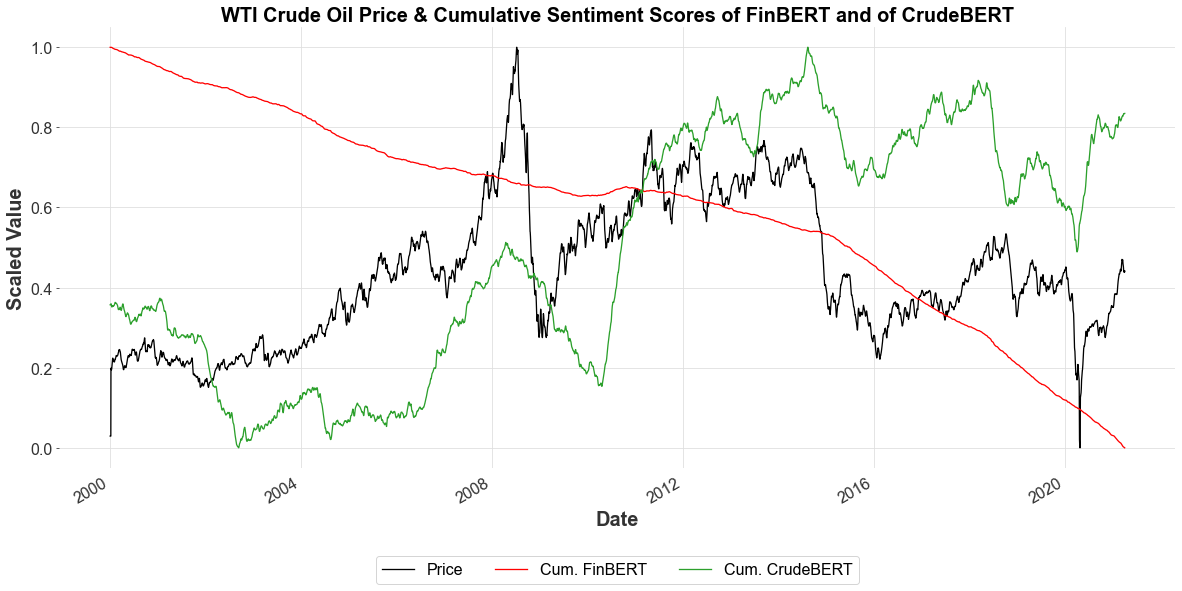

In [29]:
plot_name = "WTI Crude Oil Price & Cumulative Sentiment Scores of FinBERT and of CrudeBERT"
fsl = 20
fst = 16
plt.rcParams['font.sans-serif'] = "Arial"
plt.figure(dpi=600);
plt.figure(figsize=(20, 9))
plt.title(plot_name, fontsize=fsl, weight='bold')
series_price_scaled.plot(color='black', x_compat=True, label='Price')
series_sentiment_scaled.plot(color='red', x_compat=True, label='Cum. FinBERT')
series_sentiment_scaled2.plot(color='tab:green', x_compat=True, label='Cum. CrudeBERT')
#series_sentiment_scaled3.plot(color='gold', x_compat=True, label='Cum. CrudeBERTv2')
#series_sentiment_scaled4.plot(color='darkmagenta', x_compat=True, label='Cum. CrudeBERTv2_T4')
#series_sentiment_scaled5.plot(color='deepskyblue', x_compat=True, label='Cum. CrudeBERTv2_GT')
plt.legend(fontsize=fst,loc='upper center', bbox_to_anchor= (0.5, -0.2), ncol=6, borderaxespad=0, frameon=True)
plt.xticks(fontsize=fst)
plt.yticks(fontsize=fst)
plt.xlabel('Date', fontsize=fsl)
plt.ylabel('Scaled Value', fontsize=fsl)
plt.savefig('C:/Users/KAPLAN/Desktop/graphs_mt/'+plot_name+'.png', dpi=1200, bbox_inches="tight")